# XGBoost
This notebook will work through creating the XGboost code.

In [18]:
%pip install pandas numpy xgboost sklearn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [19]:
import xgboost as xgb
from sklearn import metrics
import pandas as pd
import numpy as np

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import f1_score


## Set up all variables needed for XGBoost
The set of variables below are needed for XGBoost. A note on the variables:
- eta = learning rate
- num_class = 20 as there are 20 MIC values
- object = "multi:softprob" This will have the prediction be probability of a datapoint being each MIC value (requires num_class)
- early_stopping_rounds = Used in Cross-Validation to stop early when the loss does not decrease after this number of rounds

In [20]:
num_folds = 5
objective = "multi:softprob"
num_classes = 19    # 20 possible MICs (not including NaN which is -1)
max_depth=5
eta=0.2
early_stopping_rounds=10

## Load data
Load the preprocessed training/testing data

In [21]:
ompk35 = pd.read_csv("../data/processed/form_3_ompk35.csv", index_col=0)
ompk36 = pd.read_csv("../data/processed/form_3_ompk36.csv", index_col=0)
ompk37 = pd.read_csv("../data/processed/form_3_ompk37.csv", index_col=0)



labels = pd.read_csv("../data/processed/labels.csv", index_col=0)
set_mics = pd.read_csv("../data/processed/mic_set.csv")

## Rename columns
We will be merging all columns together and performing an inner join on the rows. In order to do that, we need to make sure all columns for each gene have different names. Otherwise, the columns will be merged.

In [22]:
def set_columns(df, gene_name):
    df = df.set_axis([i for i in range(len(df.columns))], axis=1)
    df = df.add_prefix(f'{gene_name}_')
    return df

In [23]:
ompk35 = set_columns(ompk35, 'ompk35')
ompk36 = set_columns(ompk36, 'ompk36')
ompk37 = set_columns(ompk37, 'ompk37')

In [24]:
form_3 = pd.concat([ompk35, ompk36, ompk37], axis=1, join='inner')

In [25]:
form_3.head()

,ompk35_0,ompk35_1,ompk35_2,ompk35_3,ompk35_4,ompk35_5,ompk35_6,ompk35_7,ompk35_8,ompk35_9,...,ompk37_375,ompk37_376,ompk37_377,ompk37_378,ompk37_379,ompk37_380,ompk37_381,ompk37_382,ompk37_383,ompk37_384
Name,,,,,,,,,,,,,,,,,,,,,
Sentry-2016-958127,12,12,23,24,24,24,24,24,24,24,...,19,0,10,7,10,19,18,5,13,22
Sentry-2016-965615,12,12,23,24,24,24,24,24,24,24,...,19,0,10,7,10,19,18,5,13,22
Sentry-2016-965666,12,12,23,24,24,24,24,24,24,24,...,19,0,10,7,10,19,18,5,13,22
Sentry-2016-977317,12,12,23,24,24,24,24,24,24,24,...,19,0,10,7,10,19,18,5,13,22
Sentry-2017-1024192,12,12,23,24,24,24,24,24,24,24,...,19,0,10,7,10,19,18,5,13,22


## Setting labels
The labels contain all isolates that have no holes for at least 1 gene. However, we want to get isolates that have no holes for all genes. For that, we will need to shrink the list of labels down to only have isolates that are in `form_3` variable.

In [26]:
# Show that the numbers are off
print(len(labels.index))
print(len(form_3.index))

2864
1225


In [27]:
labels = labels[labels.index.isin(form_3.index)]

In [28]:
# Show that the numbers match now
print(len(labels.index))
print(len(form_3.index))

1225
1225


## Sorting data and labels
The labels and data must be in sorted order when training. Otherwise, the an MIC value could be matched up with the wrong datapoint.

In [29]:
labels = labels.sort_index()
form_3 = form_3.sort_index()
labels

,Antibiotic_1,Antibiotic_2,Antibiotic_3,Antibiotic_4,Antibiotic_5
Name,,,,,
Sentry-2016-933272,10,5,8,10,0
Sentry-2016-933582,6,4,7,6,0
Sentry-2016-934829,12,14,9,12,0
Sentry-2016-935518,11,13,9,11,0
Sentry-2016-935530,6,4,7,6,0
...,...,...,...,...,...
Sentry-2018-1087789,6,4,8,6,15
Sentry-2018-1087802,6,4,8,6,15
Sentry-2018-1087818,7,5,7,7,15


## Cross Validation
This next section will create the needed  decison matrices and perform cross validation to see how well XGBoost can predict. There are only 2 datapoints, so it is not work much, but it at least makes sure the code works.

# Adding in Update 2 from RF
See RF notebook for Update 2, but I am adding it here.

In [30]:
# Each model is for a different antibiotic, so we will only try with antibiotic 5 for right now (No NaN values and 2 different MIC values).
classes = labels['Antibiotic_1'].unique()
classes.sort()
print(classes)

# Parameters used for training
params = {'max_depth': max_depth, 'eta': eta, 'objective': objective, 'num_class': len(classes)}

[ 6  7  8  9 10 11 12]


# Update 1 (why you cannot use auc for cv)
When chosing a metric, auc is only for single classes. When you do multi-class classification (like I am here), you must chose a different metric or you will get an error. Below, I am changing the metric to be the log loss.

# Update 3 (custom f1 eval function)
To make CV results match with RF and NN, I found out how to make a custom Xgboost eval function [here](https://stackoverflow.com/a/51588485), and found out that the f1_score must be weighted [here](https://stackoverflow.com/a/56497098). Both links are to stackoverflow.

In [31]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = f1_score(y_true, np.argmax(y_pred, axis=1), average='weighted')
    return 'f1', err

# Update 4 (interpolating labels)
XGBoost requires that the labels given are in range [0, num_classes). Right now, the MICs can be any value between \[0, 19\] while the num_classes can vary below 19. An example set of MIC classes for an antibiotic could be \[ 0  3  4  5  6  7  8  9 10 11 12 13\] which would have $num\_classes=12$. That would mean any datapoint that has MIC label 13 would make the algorithm fail. The above example would need to be changed to \[ 0 1 2 3 4 5 6 7 8 9 10 11 \].

In [32]:
# This version does not work at all times, 
# def scale_labels(x, classes=[]):
#     return np.where(classes == x)[0][0]

def scale_labels(x, classes=[]):
    """Scaling down labels to be [0, num_classes)"""
    return classes.index(x)  # np.where(classes == x)[0][0]

In [33]:
labels_scaled = labels['Antibiotic_1'].apply(scale_labels, classes=list(classes))
train_dmatrix = xgb.DMatrix(form_3, label=labels_scaled)

# Cross Validation
cv_results = xgb.cv(
        params=params,
        dtrain=train_dmatrix,
        nfold=num_folds,
        early_stopping_rounds=early_stopping_rounds,
        metrics='mlogloss',
        feval=f1_eval
    )
print(cv_results)

   train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
0             1.707304            0.004726            1.724271   
1             1.561621            0.006734            1.594730   
2             1.457272            0.008775            1.505403   
3             1.380495            0.009751            1.441242   
4             1.321583            0.010221            1.395059   
5             1.274806            0.010950            1.360503   
6             1.236804            0.011195            1.334130   
7             1.205501            0.010764            1.314340   
8             1.180208            0.011219            1.299954   
9             1.159126            0.011385            1.289640   

   test-mlogloss-std  train-f1-mean  train-f1-std  test-f1-mean  test-f1-std  
0           0.006250       0.545183      0.007667      0.526298     0.019206  
1           0.011762       0.541242      0.006797      0.525258     0.018238  
2           0.015512       0.543688 

# Train a model
Train a model.

In [34]:
model = xgb.train(params=params, dtrain=train_dmatrix, num_boost_round=len(cv_results))

[17:48:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# Make some predicitons and see ROC and AUROC
Next is making some predictions and getting an overall performance of the model.

In [35]:
predictions = model.predict(train_dmatrix)
print(predictions)

[[0.27822486 0.22114076 0.06651186 ... 0.13751519 0.12210197 0.10228736]
 [0.5778035  0.10839722 0.05453067 ... 0.0481122  0.04977556 0.10167196]
 [0.16460901 0.04396432 0.04489587 ... 0.05502694 0.06933498 0.5731987 ]
 ...
 [0.27677554 0.19085695 0.11612356 ... 0.10423049 0.09530811 0.13474068]
 [0.6365618  0.09672841 0.04866052 ... 0.04293299 0.04441729 0.0774176 ]
 [0.6365618  0.09672841 0.04866052 ... 0.04293299 0.04441729 0.0774176 ]]


## Binarize labels
Need to binarize the labels for ROC functions

In [38]:
num_classes = len(labels['Antibiotic_1'].unique())
binary_labels = label_binarize(labels['Antibiotic_1'], classes=[i for i in range(num_classes)])
print(binary_labels.shape)

(1225, 7)


## Get False Positive and True Positive rates
For ROC, we need FPR and TPR to plot the ROC curve and get Area Under that curve, the next part gets those values as well as the Area Under for each class.

In [39]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_tru

## Micro average
Since we have a multi-class problem, we need to average all ROC's together. The best average to take is micro average.

In [40]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

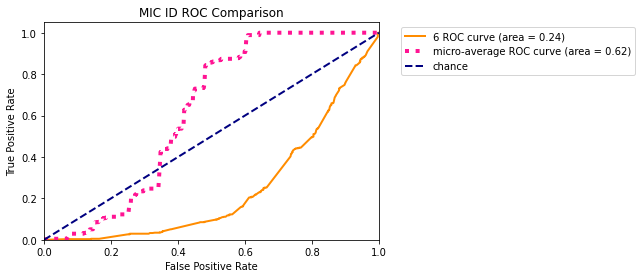

In [41]:
plt.figure()

# Plot all available labels
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'violet'])
for i, color in zip(range(num_classes), colors):
    # A curve will not be shown if TPR contains nans.
    if not np.isnan(tpr[i]).any():
        plt.plot(fpr[i], tpr[i], color=color,
                lw=2, label=f'{i} ROC curve (area = {roc_auc[i]:0.2f})')

# Plot micro average
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot chance line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="chance")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MIC ID ROC Comparison')
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.show()

# Saving the model
Now to save the model for later

## Save as binary
The next line saves the model as a binary file that can be loaded in and used again later for predicting.

In [41]:
# Save the model in a form that can be loaded and used later
model.save_model('xgboost.model')

## Save as text
Save the model in a text format to be interpreted later. Cannot be loaded and used again.

Use with [Xgbfi](https://github.com/Far0n/xgbfi) to create an image for easier reading.

In [42]:
model.dump_model('xgboost.txt')

# Feature importance
Lastly, there is finding and plotting the feature importances. Which column(s) were the most important in predicting the MIC value? We want to have the bar graph sorted, so first we will get a list of sorted indecies and use that to make the plot.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

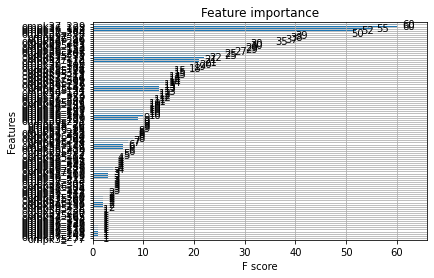

In [43]:
from xgboost import plot_importance
plot_importance(model, )

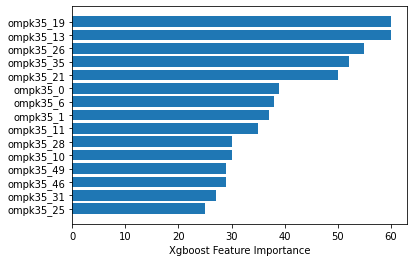

In [44]:
# Get and sort feature importances
importance_values = np.array(list(model.get_fscore().values()))
sorted_idx = np.argsort(importance_values)
sorted_feature_names = np.array(form_3.columns)[sorted_idx]
sorted_features = importance_values[sorted_idx]


# Get top 15 features
plt.barh(sorted_feature_names[-15:], sorted_features[-15:])
plt.xlabel("Xgboost Feature Importance")
plt.show()

## Save entire feature list to csv
Save the feature importance values to a CSV file.
> NOTE: Taken from: [https://stackoverflow.com/a/50902721](https://stackoverflow.com/a/50902721)

In [45]:
xgb_fea_imp=pd.DataFrame(list(model.get_fscore().items()),
                        columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)
xgb_fea_imp.to_csv('xgb_fea_imp.csv', index=False)

         feature  importance
13   ompk36_198          60
19   ompk37_229          60
26   ompk36_383          55
35   ompk37_264          52
21   ompk36_378          50
..          ...         ...
42    ompk35_77           1
86   ompk36_227           1
84   ompk36_240           1
60   ompk36_143           1
103  ompk36_235           1

[104 rows x 2 columns]


## Not all gene Amino Acids used
Note that out of the 1149 Amino Acids in the preprocessing folder, only 111 were used.

In [53]:
y_pred = np.argmax(predictions, axis=1)
y_true = labels_scaled.values
print(predictions[0])
print(predictions[1])
print(predictions[2])
print(y_pred)
print(y_true)

[0.27822486 0.22114076 0.06651186 0.07221799 0.13751519 0.12210197
 0.10228736]
[0.5778035  0.10839722 0.05453067 0.05970889 0.0481122  0.04977556
 0.10167196]
[0.16460901 0.04396432 0.04489587 0.04897015 0.05502694 0.06933498
 0.5731987 ]
[0 0 6 ... 0 0 0]
[4 0 6 ... 1 0 0]


In [43]:
f1 = pd.DataFrame([], columns=['antibiotic', 'f1_score', 'mic', 'ml'])
for m in ['xgboost', 'rf', 'nn']:
    for a in ["Antibiotic_1", "Antibiotic_2", "Antibiotic_3"]:
        scores = f1_score(y_true, y_pred, average=None, labels=range(num_classes))
        for i, s in enumerate(scores):
            if i in y_true:
                f1 = f1.append({'antibiotic': a, 'f1_score': s, 'mic': i, 'ml': m}, ignore_index=True)

f1.head()

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_divisio

,antibiotic,f1_score,mic,ml
0,Antibiotic_1,0.061927,6,xgboost
1,Antibiotic_2,0.061927,6,xgboost
2,Antibiotic_3,0.061927,6,xgboost
3,Antibiotic_1,0.061927,6,rf
4,Antibiotic_2,0.061927,6,rf


In [67]:
f1_score(y_true, y_pred, average='micro')

0.4329004329004329

# Plot F1 scores
The F1 scores can then be plotted 

The code to add text to the graph can be found [here from StackOverflow](https://stackoverflow.com/a/55157558).

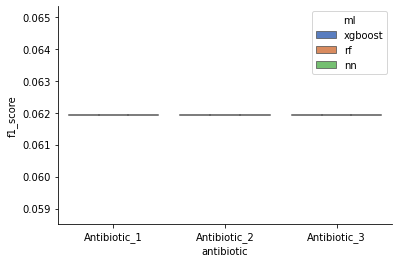

In [45]:
import seaborn as sns
# import random
# antibiotics = list(f1['antibiotic'].unique())
# mls = list(f1['ml'].unique())
g = sns.violinplot(x="antibiotic", y="f1_score", data=f1, inner='point', hue='ml', cut=0, scale="count", palette="muted")
#ax.get_legend().remove()
sns.despine() # Remove the top and right graph lines
#ax = sns.stripplot(x='antibiotic', y='f1_score', data=f1, jitter=True, edgecolor='none', alpha=.40, hue='ml')
#ax2 = sns.swarmplot(x='antibiotic', y='f1_score', data=f1, dodge=True, edgecolor='none', alpha=.40, hue='ml')

#for j, a in enumerate(antibiotics):
#    for k, m in enumerate(mls):
#        if k == 0:
#            m_diff = -0.25
#        elif k == 1:
#            m_diff = 0
#        else:
#            m_diff = 0.25
#        mics = f1[(f1['antibiotic'] == a) & (f1['ml'] == m)]
#        flag = True
#        for i in range(len(mics)):
#            if flag is True:
#                delta = 0.1
#                align = 'left'
#                flag = False
#            else:
#                delta = -0.1
#                align = 'right'
#                flag = True
#            g.text(x=j+m_diff+delta, y=mics['f1_score'].values[i], s=mics['mic'].values[i], horizontalalignment=align, size='small', color='black')



# Grid Search
Next will be grid search to see which parameters fit best for the data. This will just be testing to get grid search working, and the actual grid search will be done in script.

The original code for this came from [this Kaggle post](https://www.kaggle.com/phunter/xgboost-with-gridsearchcv) while the GPU part came from [this Kaggle post](https://www.kaggle.com/vinhnguyen/accelerating-xgboost-with-gpu).

When setting up GPU support for XGBoost, you need to have a supporting GPU and CudaNN version 10.0+. Newer versions of XGBoost have precompiled wheels that include GPU support automatically, so you do not need to build from source.

In [69]:
from sklearn.model_selection import GridSearchCV
gs_model = xgb.XGBClassifier()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'tree_method': ['gpu_hist'],
              'predictor': ['gpu_predictor'],
              'n_gpus': [1],
              'objective':[objective],
              'learning_rate': [0.5, 0.1, 0.05, 0.01], #so called 'eta' value
              'max_depth': [6, 15, 30],
              'min_child_weight': [5, 11, 15, 20],
              'silent': [1],
              'subsample': [0.2, 0.4, 0.8],
              'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
              'n_estimators': [5, 25, 50, 100, 500, 1000], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}

clf = GridSearchCV(gs_model, parameters, n_jobs=5, cv=5, scoring='f1_micro', verbose=2, refit=True)
clf.fit(form_3, labels_scaled)
results = pd.DataFrame(clf.cv_results_)
results.head()


Fitting 5 folds for each of 3456 candidates, totalling 17280 fits
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[18:37:11] WARNING: ../include/xgboost/generic_parameters.h:39: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[18:37:11] WARNING: ../src/learner.cc:222: No visible GPU is found, setting `gpu_id` to -1
[18:37:11] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


/

XGBoostError: [18:37:11] ../src/gbm/gbtree.cc:449: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.
Stack trace:
  [bt] (0) /usr/local/lib/python3.8/dist-packages/xgboost/lib/libxgboost.so(+0x8d264) [0x7f409156f264]
  [bt] (1) /usr/local/lib/python3.8/dist-packages/xgboost/lib/libxgboost.so(+0x172068) [0x7f4091654068]
  [bt] (2) /usr/local/lib/python3.8/dist-packages/xgboost/lib/libxgboost.so(+0x172542) [0x7f4091654542]
  [bt] (3) /usr/local/lib/python3.8/dist-packages/xgboost/lib/libxgboost.so(+0x1a2c21) [0x7f4091684c21]
  [bt] (4) /usr/local/lib/python3.8/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x58) [0x7f40915620c8]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.7(+0x6ff5) [0x7f41320b6ff5]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.7(+0x640a) [0x7f41320b640a]
  [bt] (7) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0x58c) [0x7f41320cf2ac]
  [bt] (8) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x137e0) [0x7f41320cf7e0]



# Update 5 (Downsampling)
After finishing all algorithms, it seems that non are able to perform well on the data. After looking, it seems that the MICs (labels) are extremely skewed making it hard for the algorithms to train. Since the data is so complex (Amino Acid sequences for 3 genes), we cannot upsample to generate new data, but we can downsample to make all classes relatively equal.

In [64]:
# First get the MIC with the minimum amount of data
mics = labels_scaled.unique()
print(f'Num MICS: {len(mics)}')
min_mic_count = 100000
for m in mics:
    # print(f"{m}: {(labels_scaled.values == m).sum()}")
    min_mic_count = min(min_mic_count, (labels_scaled.values == m).sum())
print(min_mic_count)
chosen_indicies = np.array([])
for m in mics:
    chosen_indicies = np.append(chosen_indicies, np.random.choice(labels_scaled[labels_scaled == m].index, min_mic_count, replace=False))

print(len(labels_scaled))
labels_scaled = labels_scaled[chosen_indicies]
print(len(labels_scaled))
print()
print(len(form_3))
form_3 = form_3[form_3.index.isin(chosen_indicies)]
print(len(form_3))


train_dmatrix = xgb.DMatrix(form_3, label=labels_scaled)
model = xgb.train(params=params, dtrain=train_dmatrix, num_boost_round=10)

Num MICS: 7
33
231
231

231
231
[18:47:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [65]:
predictions = model.predict(train_dmatrix)
print(predictions)

[[0.24048819 0.18857041 0.07756965 ... 0.1732285  0.15820093 0.08239859]
 [0.10970525 0.11671721 0.05224433 ... 0.09805379 0.08301576 0.15779142]
 [0.08805116 0.16045345 0.10897237 ... 0.16315593 0.19411485 0.12624793]
 ...
 [0.09730347 0.06798574 0.19682445 ... 0.12024324 0.16674064 0.11967921]
 [0.08805116 0.16045345 0.10897237 ... 0.16315593 0.19411485 0.12624793]
 [0.08805116 0.16045345 0.10897237 ... 0.16315593 0.19411485 0.12624793]]


In [66]:
y_pred = np.argmax(predictions, axis=1)
y_true = labels_scaled.values
print(predictions[0])
print(predictions[1])
print(predictions[2])
print(y_pred)
print(y_true)

[0.24048819 0.18857041 0.07756965 0.07954372 0.1732285  0.15820093
 0.08239859]
[0.10970525 0.11671721 0.05224433 0.38247222 0.09805379 0.08301576
 0.15779142]
[0.08805116 0.16045345 0.10897237 0.15900427 0.16315593 0.19411485
 0.12624793]
[0 3 5 5 4 2 4 5 4 4 4 4 4 4 5 5 4 4 2 4 4 4 2 2 2 2 6 2 2 4 4 5 3 2 1 5 3
 0 5 1 0 0 4 4 4 1 0 2 4 1 0 2 0 0 2 3 2 0 3 4 0 2 1 0 0 4 6 5 2 6 6 2 3 6
 6 4 2 5 3 6 6 6 6 6 6 4 6 5 6 6 6 6 6 6 3 5 5 0 3 3 6 6 5 5 5 3 4 1 5 0 0
 5 5 5 5 3 2 5 5 5 6 5 5 2 5 2 2 4 3 5 5 2 6 6 1 6 6 4 3 1 2 5 4 0 5 5 1 4
 3 2 5 1 1 2 0 1 5 1 5 1 2 1 1 5 3 3 1 2 3 5 4 3 5 2 5 4 1 3 3 5 3 3 6 3 3
 3 3 4 3 3 5 4 5 3 3 3 0 0 2 6 1 4 6 4 6 4 2 2 2 0 2 2 1 0 6 2 2 2 6 6 4 2
 2 2 2 2 3 3 3 5 5]
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 1 

In [68]:
f1_score(y_true, y_pred, average='micro')

0.4329004329004329